In [1]:
import sys
#sys.path.append('..')
from QAOA import QAOArunner
from MaxCutProblem import MaxCutProblem
import params
from rustworkx.visualization import mpl_draw as draw_graph
from old_jupyter_vizualisers.load_data import load_graph_from_csv

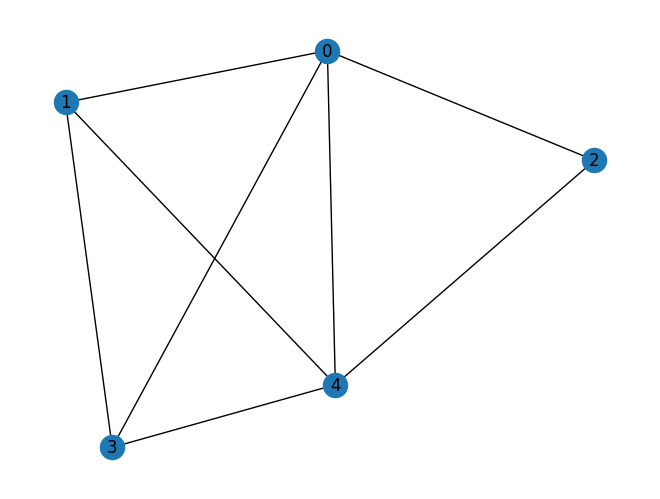

In [2]:
problem = MaxCutProblem()
graphs = problem.get_erdos_renyi_graphs([5,7,9])

graph = graphs[1]
#graph = problem.get_graph_by_name(name)
#graph = load_graph_from_csv('data/11_nodes_links_scand.csv')
#draw_graph(graph, with_labels=True)

draw_graph(graph, with_labels=True)

SparsePauliOp(['IIIZZ', 'IIZIZ', 'IZIIZ', 'ZIIIZ', 'IZIZI', 'ZIIZI', 'ZIZII', 'ZZIII'],
              coeffs=[0.25 +0.j, 0.5  +0.j, 0.125+0.j, 0.25 +0.j, 0.125+0.j, 0.375+0.j,
 0.125+0.j, 0.5  +0.j])


c:\Users\torbjsme\Master\QAOA\myenv\lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


[1, 1, 0, 0, 0]
2.75
66
[2.72956024 1.67399903 3.2658417  2.71061176 3.14177327 1.42089518
 3.041703   2.62242953 2.9039624  1.55196258 3.0773152  1.58343173]


c:\Users\torbjsme\Master\QAOA\myenv\lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


m 0.063


c:\Users\torbjsme\Master\QAOA\myenv\lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


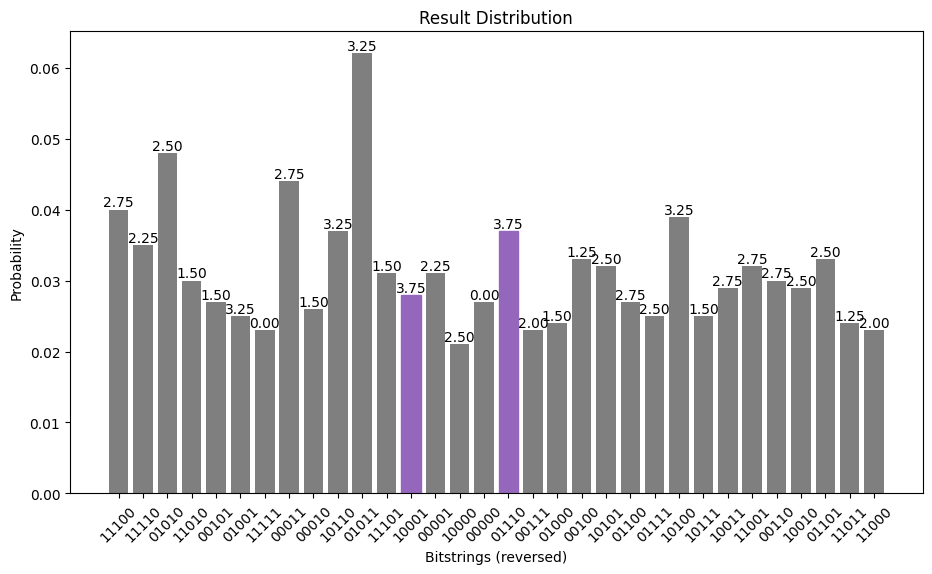

In [3]:
quantum = QAOArunner(graph=graph, 
                     backend_mode = 'noisy_sampling',
                     param_initialization= 'gaussian',
                     qaoa_variant='vanilla', 
                     optimizer='COBYLA',
                     warm_start=False,
                     depth = 6,
                     vertexcover=False,
                     amount_shots = 1000,
                     max_tol = 1e-2,
                     lagrangian_multiplier=2
                     )

quantum.build_circuit()
print(quantum.cost_hamiltonian)

quantum.run()
print(quantum.solution)
print(quantum.evaluate_sample())
print(quantum.fev)
print(quantum.result.x)
print('m',quantum.get_prob_measure_optimal())
quantum.print_bitstrings()

In [4]:
job = quantum.get_job_custom_circuit(quantum.circuit)
print((job.result()[0].data))
print(quantum.final_params)

DataBin(meas=BitArray(<shape=(), num_shots=1000, num_bits=5>))
[2.72956024 1.67399903 3.2658417  2.71061176 3.14177327 1.42089518
 3.041703   2.62242953 2.9039624  1.55196258 3.0773152  1.58343173]


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from qiskit_ibm_runtime import EstimatorV2 as Estimator
# Define the grid resolution
num_points = 100
gamma_vals = np.linspace(0, 2 * np.pi, num_points)
beta_vals = np.linspace(0, np.pi, num_points)
Gamma, Beta = np.meshgrid(gamma_vals, beta_vals)
Z = np.zeros_like(Gamma)



minvertexcover = False

quantum = QAOArunner(graph=graph, 
                     backend_mode='statevector',
                     param_initialization= 'gaussian',
                     qaoa_variant='vanilla', 
                     optimizer='COBYLA',
                     warm_start=False,
                     depth = 1,
                     vertexcover=minvertexcover,
                     amount_shots = 5000,
                     max_tol = 1e-8,
                     lagrangian_multiplier=2
                     )
quantum.build_circuit()
estimator = Estimator(mode=quantum.backend)
estimator.options.default_shots = 5000
# Evaluate cost function at each grid point
for i in tqdm(range(Gamma.shape[0]), desc="Evaluating energy landscape"):
    for j in range(Gamma.shape[1]):
        params = np.array([Gamma[i, j], Beta[i, j]])  # Format your params as needed
        Z[i, j] = quantum.cost_func_estimator(params, quantum.circuit, quantum.cost_hamiltonian,estimator)

# Plot the energy landscape
plt.figure(figsize=(8, 6))
cp = plt.contourf(Gamma, Beta, Z, levels=50)
plt.colorbar(cp, label='Energy')
plt.title("Energy Landscape over [γ, β]")
plt.xlabel("Gamma (γ)")
plt.ylabel("Beta (β)")
plt.show()


Evaluating energy landscape:   2%|▏         | 2/100 [00:15<12:24,  7.59s/it]


KeyboardInterrupt: 

In [ ]:
import pandas as pd

# Save Z as a CSV file
df_z = pd.DataFrame({'x': Gamma.ravel(), 'y': Beta.ravel(), 'z': Z.ravel()})
df_z.columns = ['x', 'y', 'z']
df_z.to_csv('percentage_measure_optimal_erdos_renyi_5_2_MaxCut.csv', index=False)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

strin = 'MinVertexCover' if minvertexcover else 'MaxCut'

import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(z=Z, x=Gamma, y=Beta, colorscale='Viridis')])
fig.update_layout(
    title=f"Percent chance of sampling optimal solution given [γ, β] for Erdos Renyi graph size 5, high prob of edges, for {strin}",
    scene=dict(
        xaxis_title="Gamma (γ)",
        yaxis_title="Beta (β)",
        zaxis_title="Energy"
    )
)
fig.show()



In [ ]:
quantum.solver.plot_result(quantum.calculate_solution())

In [ ]:

quantum.circuit.draw('mpl', fold=False, idle_wires=False)


In [ ]:
import networkx as nx
draw_graph(graph, with_labels=True)


nx_graph = nx.Graph()
nx_graph.add_nodes_from(range(graph.num_nodes()))
nx_graph.add_weighted_edges_from(graph.weighted_edge_list())
graph6_str = nx.to_graph6_bytes(nx_graph).decode().strip()
print(f"{name} (graph6): {graph6_str}")

In [ ]:
import networkx as nx
import rustworkx as rx
import matplotlib.pyplot as plt

for g in problem.get_paper_graphs():
    draw_graph(g, with_labels=True)
    nx_graph = nx.Graph()
    nx_graph.add_nodes_from(range(g.num_nodes()))
    nx_graph.add_weighted_edges_from(g.weighted_edge_list())
    graph6_str = nx.to_graph6_bytes(nx_graph).decode().strip()
    print(f"Graph (graph6): {graph6_str}")
    plt.show()

In [ ]:
problem.draw_representative_graphs()

In [ ]:
problem.print_graphs()

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token=params.api_key
)

job = service.job('cxg38m26t010008cmsng') #You can get this on the ibmq web interface 
job_result = job.result()
job_approx_execution_time = job.metrics() 
print(job_approx_execution_time)
for key, value in job_approx_execution_time.items():
    print(f"{key}: {value}")

In [6]:
import itertools

settings = {
'backend_mode' : ['statevector'],
'warm_start' : [False,True],
'vertexcover' : [True]
}

keys = settings.keys()
values = settings.values()

combinations = [dict(zip(keys, combination)) for combination in itertools.product(*values)]
print(f'echo "{combinations}" > test_settings.txt')
#print(len(combinations))

echo "[{'backend_mode': 'statevector', 'warm_start': False, 'vertexcover': True}, {'backend_mode': 'statevector', 'warm_start': True, 'vertexcover': True}]" > test_settings.txt


In [ ]:
import matplotlib.pyplot as plt

# Assuming quantum.objective_func_vals and quantum.classical_objective_func_vals are lists or arrays
plt.figure(figsize=(10, 6))
plt.plot(quantum.objective_func_vals, label='Quantum Objective Function Values')
plt.plot(quantum.classical_objective_func_vals, label='Classical Objective Function Values', linestyle='--')
plt.xlabel('Iterations')
plt.ylabel('Objective Function Value')
plt.title('Objective Function Values Over Iterations')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
import numpy as np
pub = (quantum.circuit,)
sampler = Sampler(mode=quantum.backend)
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
print(counts_int)
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]





In [ ]:
sorted_final_distribution_int = dict(sorted(final_distribution_int.items(), key=lambda item: item[1]))
print(sorted_final_distribution_int)